In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


titanic_url = ('https://raw.githubusercontent.com/amueller/'
               'scipy-2017-sklearn/091d371/notebooks/datasets/titanic3.csv')
titanic = pd.read_csv(titanic_url)
titanic['random_cat'] = np.random.randint(3, size=titanic.shape[0])
titanic['random_num'] = np.random.randn(titanic.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

data = titanic[categorical_columns + numerical_columns]
labels = titanic['survived']

In [4]:
data.head(10)

,pclass,sex,embarked,random_cat,age,sibsp,parch,fare,random_num
0,1,female,S,0,29.0000,0,0,211.3375,-1.331348
1,1,male,S,0,0.9167,1,2,151.5500,-1.250649
2,1,female,S,2,2.0000,1,2,151.5500,-1.696596
3,1,male,S,1,30.0000,1,2,151.5500,-0.023911
4,1,female,S,0,25.0000,1,2,151.5500,-0.030937
5,1,male,S,1,48.0000,0,0,26.5500,0.267747
6,1,female,S,1,63.0000,1,0,77.9583,-0.312384
7,1,male,S,0,39.0000,0,0,0.0000,-0.641420
8,1,female,S,0,53.0000,2,0,51.4792,1.041660
9,1,male,C,1,71.0000,0,0,49.5042,-0.582529


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, stratify=labels, random_state=42)

## Random Forest importances of an overfitting model

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_inspection import permutation_importance
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_estimators=100, min_samples_leaf=1,
                                          random_state=42))
])
rf.fit(X_train, y_train)


print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.811


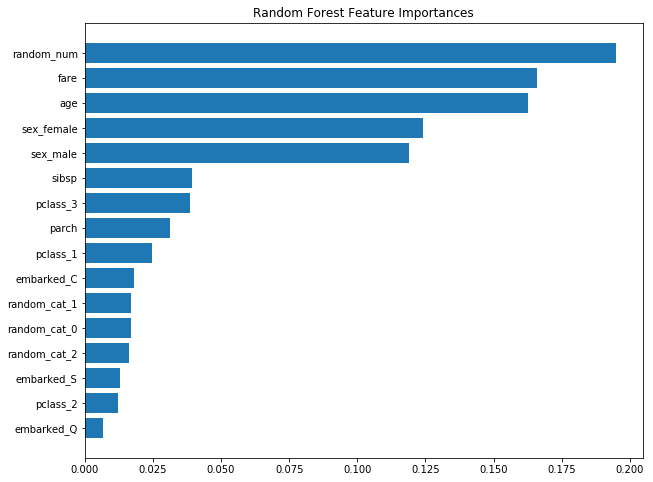

In [7]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = []
for col, cats in zip(categorical_columns, ohe.categories_):
    for cat in cats:
        feature_names.append("{}_{}".format(col, cat))
feature_names = np.array(feature_names + numerical_columns)

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
_, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances");

## Permutation Importances on the test set

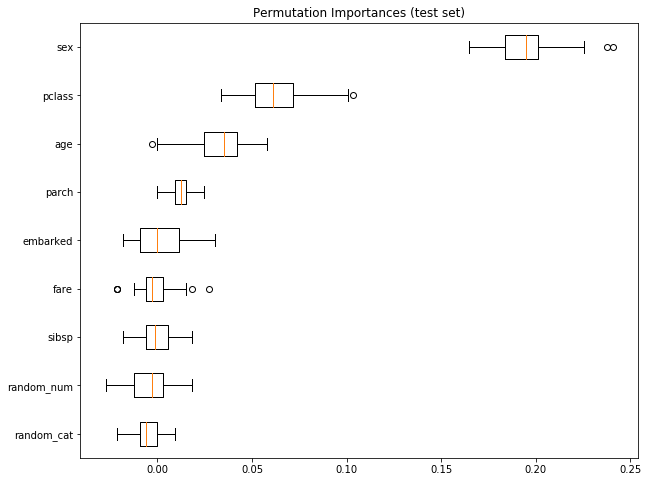

In [8]:
permute_importance = permutation_importance(rf, X_test, y_test, n_rounds=30)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

_, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)");

## Permutation importances on the training set

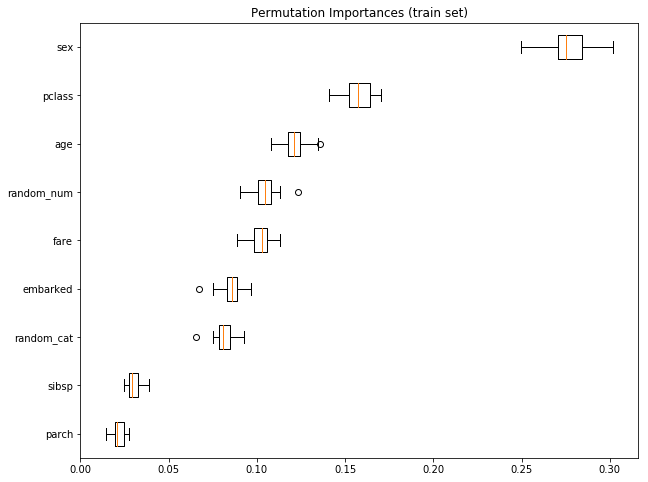

In [9]:
permute_importance = permutation_importance(rf, X_train, y_train, n_rounds=30)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

_, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)");

## Same analysis on non-overfitting model

In [10]:
rf.named_steps["classifier"].set_params(min_samples_leaf=10)
rf.fit(X_train, y_train)
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.823
RF test accuracy: 0.829


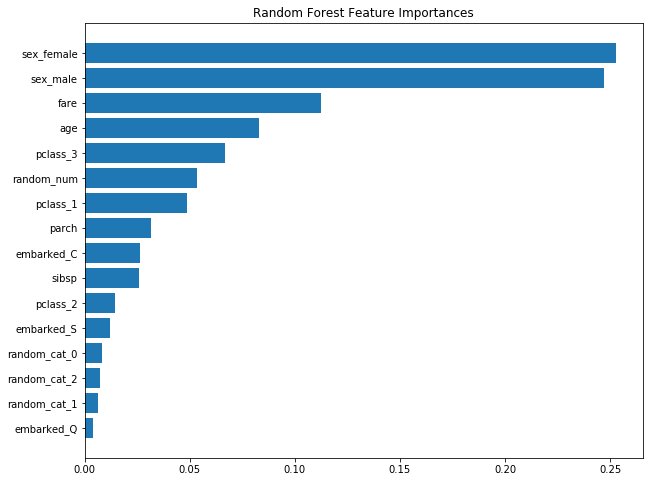

In [11]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = []
for col, cats in zip(categorical_columns, ohe.categories_):
    for cat in cats:
        feature_names.append("{}_{}".format(col, cat))
feature_names = np.array(feature_names + numerical_columns)

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
_, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances");

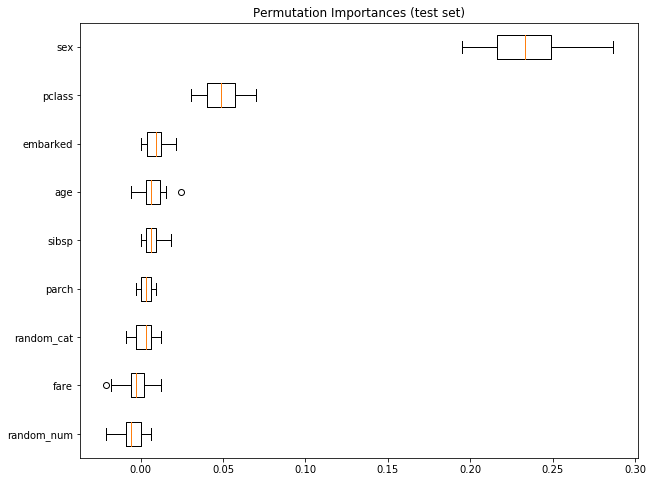

In [12]:
permute_importance = permutation_importance(rf, X_test, y_test, n_rounds=30)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

_, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)");

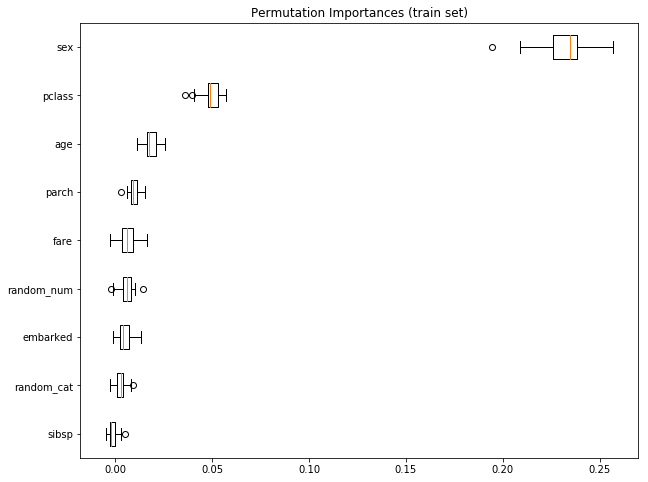

In [13]:
permute_importance = permutation_importance(rf, X_train, y_train, n_rounds=30)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

_, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)");